Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [5]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split=0.2,subset="training",
                                                               image_size=(img_height,img_width),batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split=0.2,subset="validation",
                                                             image_size=(img_height, img_width),batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

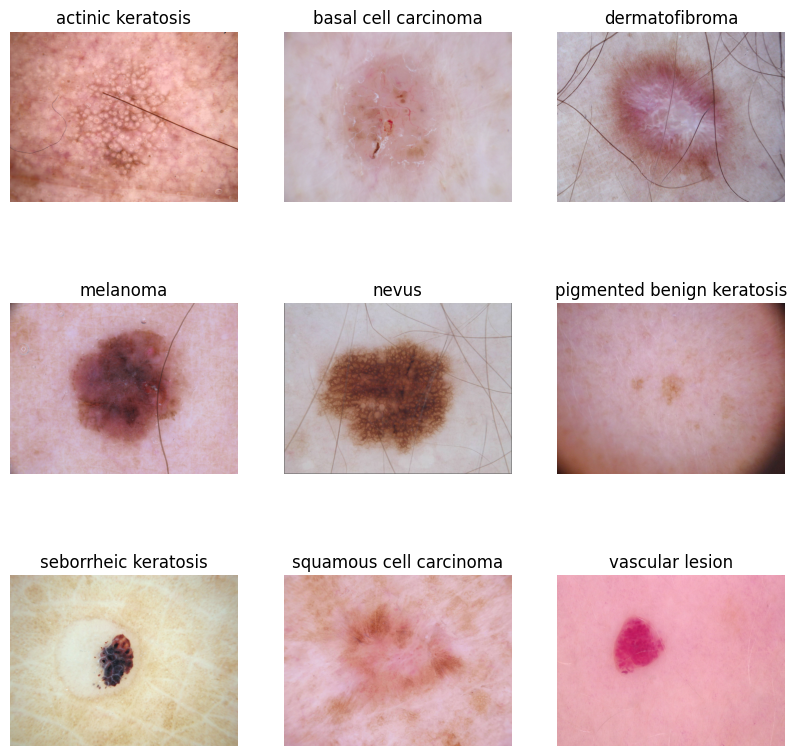

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
fig = plt.figure(figsize=(10,10))
for i in range(len(class_names)):
    plt.subplot(3,3,i+1)
    image = plt.imread(str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[i]))
    plt.title(class_names[i])
    plt.imshow(image)
    plt.axis('off')
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
model = Sequential()
model.add(layers.Rescaling(1/255.0, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32,kernel_size=(3,3),padding="Same",activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),padding="Same",activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),padding="Same",activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),padding="Same",activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(16,kernel_size=(7,7),padding="Same",activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(11,11),padding="Same",activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,kernel_size=(3,3),padding="Same",activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 498s 3s/step - loss: 2.0569 - accuracy: 0.1948 - val_loss: 2.0608 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 73ms/step - loss: 1.9892 - accuracy: 0.2048 - val_loss: 1.9185 - val_accuracy: 0.2438
Epoch 3/20
56/56 [==============================] - 4s 64ms/step - loss: 1.8717 - accuracy: 0.2924 - val_loss: 1.9041 - val_accuracy: 0.2349
Epoch 4/20
56/56 [==============================] - 3s 54ms/step - loss: 1.8055 - accuracy: 0.3170 - val_loss: 1.7118 - val_accuracy: 0.3669
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 1.6866 - accuracy: 0.3823 - val_loss: 1.6368 - val_accuracy: 0.4072
Epoch 6/20
56/56 [==============================] - 4s 74ms/step - loss: 1.6627 - accuracy: 0.4085 - val_loss: 1.6302 - val_accuracy: 0.4295
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 1.5908 - accuracy: 0.4325 - val_loss: 1.5072 - val_accuracy: 0.4720
Epoch 8/20
56

### Visualizing training results

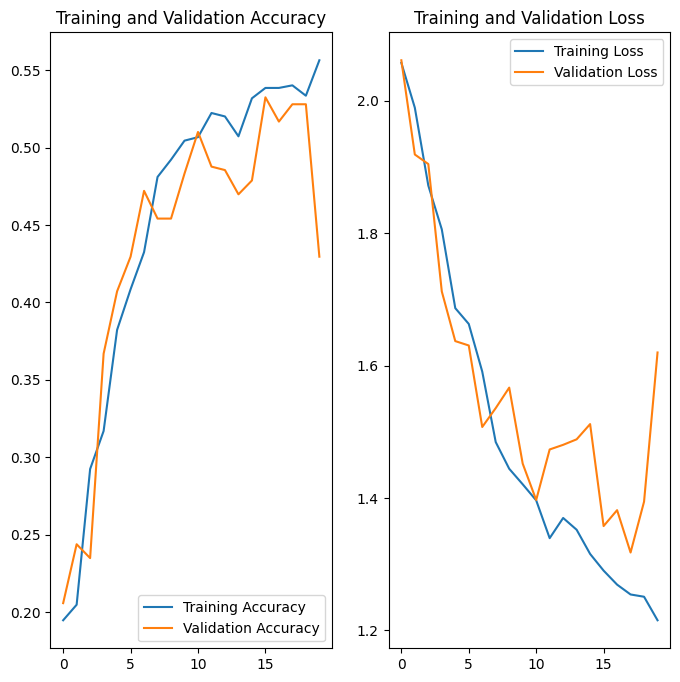

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

*   The training accuracy and validation accurcy are almost same and at the same time, they are very low, which indicates that the model is underfitting.
*    Training loss is very low but we see that the validation loss is fluctuating



In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit,
# choose an appropriate data augumentation strategy.
# Your code goes here
agumentation_data = tf.keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=(img_height, img_width,3)),
     layers.experimental.preprocessing.RandomRotation(0.2),
     layers.experimental.preprocessing.RandomZoom(0.3),
     layers.experimental.preprocessing.RandomContrast(0.1)
     ]
)


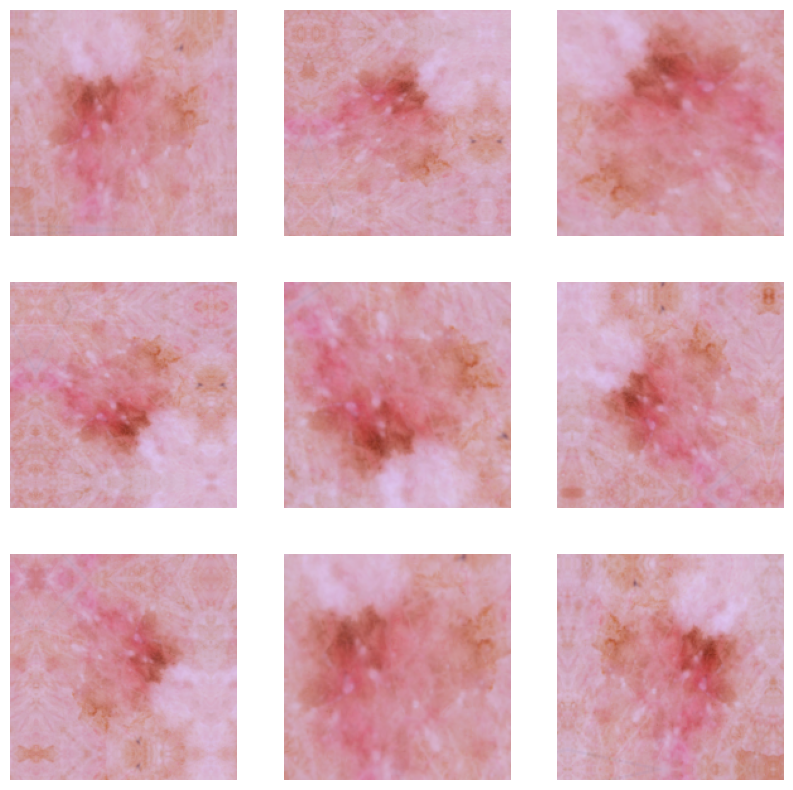

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10,10))
for images,_ in train_ds.take(1):
  for i in range(9):
    augmented_images = agumentation_data(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
model = Sequential()
model.add(layers.Rescaling(1/255.0, input_shape=(img_height, img_width,3)))
model.add(agumentation_data)

model.add(Conv2D(32, kernel_size=(3,3), padding="Same", activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), padding="Same", activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, kernel_size=(3,3), padding="Same", activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), padding="Same", activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(16, kernel_size=(7,7), padding="Same", activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(11,11), padding="Same", activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3,3), padding="Same", activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))


### Compiling the model

In [22]:
## Your code goes here

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 6s 64ms/step - loss: 2.0681 - accuracy: 0.1920 - val_loss: 2.0367 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 58ms/step - loss: 2.0276 - accuracy: 0.2070 - val_loss: 2.0226 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 2.0204 - accuracy: 0.1998 - val_loss: 2.0214 - val_accuracy: 0.2148
Epoch 4/20
56/56 [==============================] - 3s 57ms/step - loss: 1.9813 - accuracy: 0.2355 - val_loss: 1.9585 - val_accuracy: 0.2819
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 1.9483 - accuracy: 0.2589 - val_loss: 1.8332 - val_accuracy: 0.2931
Epoch 6/20
56/56 [==============================] - 3s 58ms/step - loss: 1.8346 - accuracy: 0.2835 - val_loss: 1.8334 - val_accuracy: 0.3244
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.7822 - accuracy: 0.3002 - val_loss: 1.7124 - val_accuracy: 0.3826
Epoch 8/20
56

### Visualizing the results

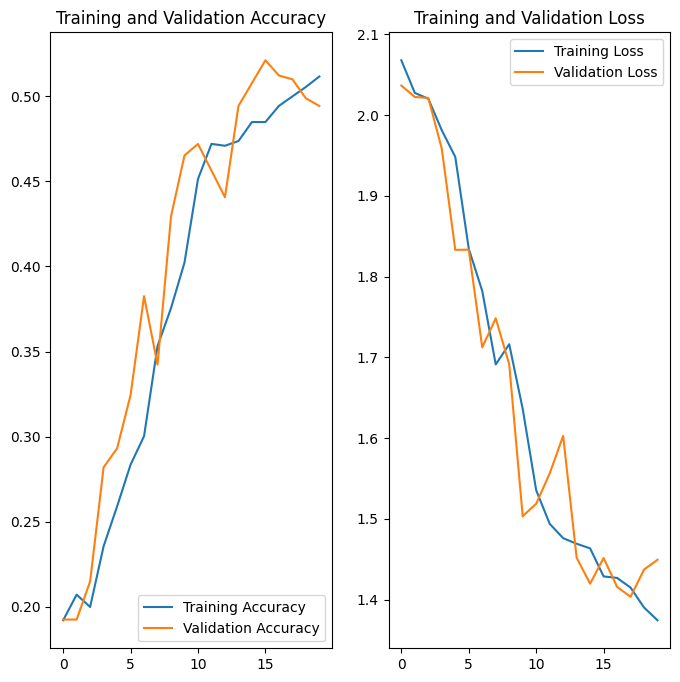

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?



*   The training accuracy and validation accuracy are almost same. But still the accuracy is very low. The model requires more epochs to train. Also we should check and hangle the class imbalance.



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<ipython-input-26-ba6f5b0b5f2b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_dif = class_dif.append({'class':name, 'number':number},ignore_index=True)
<ipython-input-26-ba6f5b0b5f2b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_dif = class_dif.append({'class':name, 'number':number},ignore_index=True)
<ipython-input-26-ba6f5b0b5f2b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_dif = class_dif.append({'class':name, 'number':number},ignore_index=True)
<ipython-input-26-ba6f5b0b5f2b>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_dif = class_dif.append({'class':name, 'number':number},ignore_index=True)


                        class  number
0           actinic keratosis     114
1        basal cell carcinoma     376
2              dermatofibroma      95
3                    melanoma     438
4                       nevus     357
5  pigmented benign keratosis     462
6        seborrheic keratosis      77
7     squamous cell carcinoma     181
8             vascular lesion     139


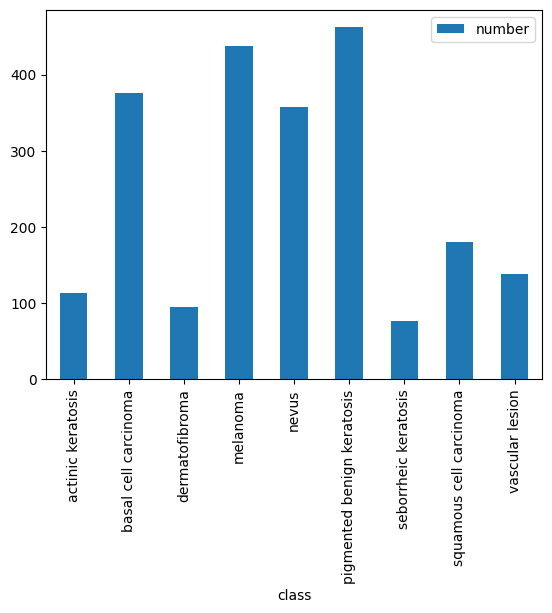

In [26]:
## Your code goes here.
class_dif = pd.DataFrame()
for i in range(len(class_names)):
  name = class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_dif = class_dif.append({'class':name, 'number':number},ignore_index=True)

print(class_dif)

class_dif.plot.bar(x="class", y="number", rot=90)
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### seborrheic keratosis      
#### - Which classes dominate the data in terms proportionate number of samples?
#### pigmented benign keratosis     

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E3687ED3400>: 100%|██████████| 500/500 [00:19<00:00, 25.49 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E3687E93A90>: 100%|██████████| 500/500 [00:17<00:00, 28.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E3687D32B00>: 100%|██████████| 500/500 [00:19<00:00, 25.95 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E3682E0F220>: 100%|██████████| 500/500 [01:15<00:00,  6.65 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=576x768 at 0x7E3682F35E70>: 100%|██████████| 500/500 [01:21<00:00,  6.10 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E3687D8AFE0>: 100%|██████████| 500/500 [00:18<00:00, 27.13 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E36830C3790>: 100%|██████████| 500/500 [00:38<00:00, 13.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E3687E96440>: 100%|██████████| 500/500 [00:17<00:00, 28.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E3694127970>: 100%|██████████| 500/500 [00:18<00:00, 27.21 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000497.jpg_1550df33-b265-4bcf-8545-c5de055ec122.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0024470.jpg_b4ed63d4-1e30-44fd-842e-1f5ac8a975ff.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000419.jpg_a56fab7c-11f5-4142-8fb6-63b496ac7fa0.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027884.jpg_8b062ec4-296f-41f0-9d9e-ed63c84d7e34.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026575.jpg_593456ea-ab14-411f-b1e2-811df8e7bd44.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Tr

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [37]:
new_df['Label'].value_counts()

nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
actinic keratosis             500
squamous cell carcinoma       500
melanoma                      500
dermatofibroma                500
basal cell carcinoma          500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
qdata_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [42]:
## your code goes here

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))

model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## your code goes here
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [45]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/50
169/169 [==============================] - 41s 236ms/step - loss: 1.7457 - accuracy: 0.3168 - val_loss: 1.6529 - val_accuracy: 0.3779
Epoch 2/50
169/169 [==============================] - 41s 236ms/step - loss: 1.6295 - accuracy: 0.3767 - val_loss: 1.6141 - val_accuracy: 0.3697
Epoch 3/50
169/169 [==============================] - 41s 239ms/step - loss: 1.5843 - accuracy: 0.3865 - val_loss: 1.3961 - val_accuracy: 0.4640
Epoch 4/50
169/169 [==============================] - 42s 239ms/step - loss: 1.5101 - accuracy: 0.4119 - val_loss: 1.5314 - val_accuracy: 0.4157
Epoch 5/50
169/169 [==============================] - 42s 241ms/step - loss: 1.4866 - accuracy: 0.4240 - val_loss: 1.3282 - val_accuracy: 0.4781
Epoch 6/50
169/169 [==============================] - 46s 266ms/step - loss: 1.4320 - accuracy: 0.4431 - val_loss: 1.2954 - val_accuracy: 0.4929
Epoch 7/50
169/169 [==============================] - 44s 249ms/step - loss: 1.3858 - accuracy: 0.4577 - val_loss: 1.2417 - val_ac

#### **Todo:**  Visualize the model results

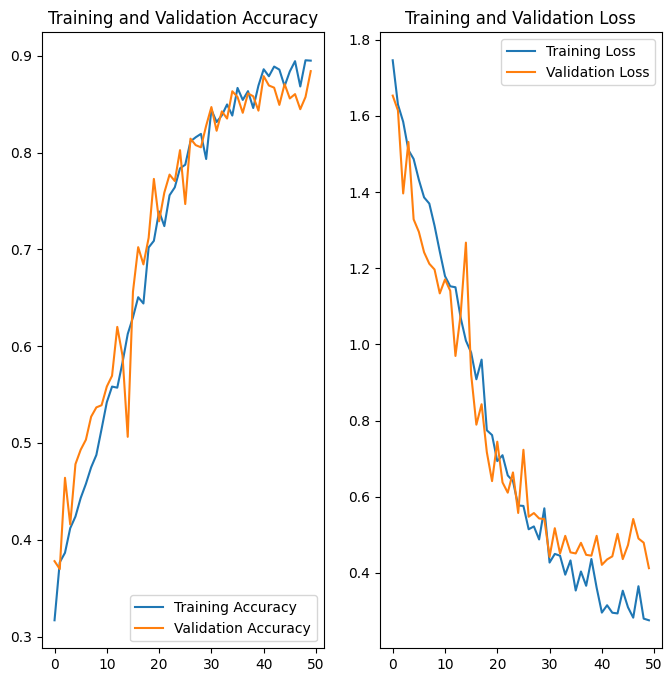

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1.   The training accuracy and validation accuracy are almost same. This is a sign of good fit.
2.   The training loss and validation loss are almost same. This is a sign of good fit.
3.  The Validation accuracy is 0.88 which is good. The model is able to classify the images with 88% accuracy.







